In [25]:
suppressPackageStartupMessages({
    library(tidymodels)
    library(treesnip)
    library(tidyverse)
    library(keras)
})

In [212]:
model <- keras_model_sequential()

In [213]:
model %>%
layer_dense(units = 40, activation = 'relu', input_shape = c(3)) %>%
layer_dense(units = 2,activation = 'softmax')

In [218]:
# not workin' yet
f1_loss <- function(y_true, y_pred) {
    
    y_pred <- k_argmax(y_pred,axis = -1)
    y_pred <- k_one_hot(y_pred,num_classes = 2)
    tp <- k_sum(k_cast(y_true*y_pred, 'float'), axis=2)
    tn <- k_sum(k_cast((1-y_true)*(1-y_pred), 'float'), axis=2)
    fp <- k_sum(k_cast((1-y_true)*y_pred, 'float'), axis=2)
    fn <- k_sum(k_cast(y_true*(1-y_pred), 'float'), axis=2)

    p <- tp / (tp + fp + k_epsilon())
    r <- tp / (tp + fn + k_epsilon())

    f1 <- 2*p*r / (p+r+k_epsilon())
    #f1 = k(k_isnan(f1), k_zeros_like(f1), f1)
    #f1 <- ifelse(is.na(f1),k_zeros_like(f1),f1)
    1 - k_mean(f1)
}

In [215]:
model %>% compile(
  loss = f1_loss,
  optimizer = optimizer_adam(learning_rate = 0.01),
  metrics = c('AUC')
)

In [216]:
set.seed(1)

label <- 'default'

iris1.5 <- ISLR::Default %>% mutate(default = case_when(default == 'No' ~ 0,
                                             default == 'Yes' ~ 1))

iris1.5 <- iris1.5 %>% mutate(default = factor(default,levels = 0:1))

willsee <- caret::createDataPartition(iris1.5[[label]],p = .7,list = TRUE) %>% unlist

iris2 <- iris1.5[willsee,]

iris3 <- iris1.5[-willsee,]

folds_ <- caret::createFolds(iris2[[label]],k = 5)

folds <- 1:length(folds_)

errors <- c()

predictions <- list()

iris2 <- iris2 %>% mutate(default = as.integer(as.character(default)))
iris3 <- iris3 %>% mutate(default = as.integer(as.character(default)))

for(i in folds){
    train_indices <- setdiff(folds,i)
    test_indices <- i
    
    train_set <- iris2[unlist(folds_[train_indices]),]
    test_set <- iris2[unlist(folds_[test_indices]),]
    
    tarif <- recipe(default ~ .,data = train_set) %>% 
    step_normalize(all_numeric_predictors()) %>%
    step_dummy(all_nominal_predictors()) %>%
    prep
    
    target_data <- bake(tarif,iris3)
    
    train_set <- bake(tarif,train_set)
    test_set <- bake(tarif,test_set)
    
    train_y <- train_set[,label] %>% as.matrix %>% to_categorical
    test_y <- test_set[,label]%>% as.matrix %>% to_categorical
    test_y2 <- test_set[,label]%>% as.matrix
    
    train_x <- train_set[, -which(names(train_set) == label)]%>% as.matrix
    test_x <- test_set[, -which(names(test_set) == label)]%>% as.matrix
    
    target_data <- target_data[, -which(names(train_set) == label)]%>% as.matrix
    history <- model %>% fit(
      train_x, train_y, 
      epochs = 30, batch_size = 128, 
      validation_data = list(test_x,test_y),
      callbacks = list(callback_early_stopping(
                        monitor = "val_loss",
                        patience = 10,
                        verbose = 1,
                        mode = "auto",
                        restore_best_weights = TRUE
                        )
    ),
    class_weight = list('0' = sqrt(sum(test_y)),'1' = sqrt(sum(test_y == 0)))
    )

    preds <- model %>% predict(test_x)  %>% 
                        as.data.frame %>%
                        mutate('class'=names(.)[apply(., 1, which.max)]) %>%
                        mutate(class = case_when(class == 'V1' ~ 0,
                                                 class == 'V2' ~ 1)) %>%
                        select(class) %>%
                        pull
    
    error <- yardstick::f_meas_vec(truth = as.factor(test_y2),estimate = factor(preds,levels = 0:1),event_level = "second")
    
    preds_target <- model %>% predict(target_data)  %>% 
                        as.data.frame %>%
                        mutate('class'=names(.)[apply(., 1, which.max)]) %>%
                        mutate(class = case_when(class == 'V1' ~ 0,
                                                 class == 'V2' ~ 1)) %>%
                        select(class) %>%
                        pull
    
    IRdisplay::display('**************----------**************')
    IRdisplay::display(sprintf('Fold %s F1 : %s',i,round(error,2)))
    errors[i] <- error
    
    predictions[[i]] <- preds_target
}
IRdisplay::display('**************----------**************')
IRdisplay::display(sprintf('CV Mean F1 : %s',mean(errors)))

ERROR: Error in py_call_impl(callable, dots$args, dots$keywords): ValueError: in user code:
<... omitted ...>_and_vars, name=name)
    File "C:\Users\samet.sokel\AppData\Roaming\Python\Python39\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 690, in apply_gradients
        grads_and_vars = optimizer_utils.filter_empty_gradients(grads_and_vars)
    File "C:\Users\samet.sokel\AppData\Roaming\Python\Python39\site-packages\keras\optimizers\optimizer_v2\utils.py", line 77, in filter_empty_gradients
        raise ValueError(

    ValueError: No gradients provided for any variable: (['dense_147/kernel:0', 'dense_147/bias:0', 'dense_146/kernel:0', 'dense_146/bias:0'],). Provided `grads_and_vars` is ((None, <tf.Variable 'dense_147/kernel:0' shape=(3, 40) dtype=float32>), (None, <tf.Variable 'dense_147/bias:0' shape=(40,) dtype=float32>), (None, <tf.Variable 'dense_146/kernel:0' shape=(40, 2) dtype=float32>), (None, <tf.Variable 'dense_146/bias:0' shape=(2,) dtype=float32>)).

See `reticulate::py_last_error()` for details


In [217]:
reticulate::py_last_error()

Traceback (most recent call last):
  File "C:\Users\samet.sokel\AppData\Roaming\Python\Python39\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\SAMET~1.SOK\AppData\Local\Temp\__autograph_generated_fileq3rsl50q.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "C:\Users\samet.sokel\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\samet.sokel\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\samet.sokel\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py", line 1135, in run_step  **
       

In [166]:
set.seed(1)

label <- 'default'

iris1.5 <- ISLR::Default %>% mutate(default = case_when(default == 'No' ~ 0,
                                             default == 'Yes' ~ 1))

iris1.5 <- iris1.5 %>% mutate(default = factor(default,levels = 0:1))

willsee <- caret::createDataPartition(iris1.5[[label]],p = .7,list = TRUE) %>% unlist

iris2 <- iris1.5[willsee,]

iris3 <- iris1.5[-willsee,]

folds_ <- caret::createFolds(iris2[[label]],k = 5)

folds <- 1:length(folds_)

errors <- c()

predictions <- list()

#iris2 <- iris2 %>% mutate(default = as.integer(as.character(default)))
#iris3 <- iris3 %>% mutate(default = as.integer(as.character(default)))

for(i in folds){
    train_indices <- setdiff(folds,i)
    test_indices <- i
    
    train_set <- iris2[unlist(folds_[train_indices]),]
    test_set <- iris2[unlist(folds_[test_indices]),]
    
    tarif2 <- recipe(default ~ .,data = train_set)
    
    target_data <- bake(tarif,iris3)
    
    train_set <- bake(tarif %>% prep,train_set)
    test_set <- bake(tarif%>% prep,test_set)
    
    train_y <- train_set[,label]
    test_y <- test_set[,label]
    test_y2 <- test_set[,label]%>% as.matrix
    
    train_x <- train_set[, -which(names(train_set) == label)]
    test_x <- test_set[, -which(names(test_set) == label)]
    
    target_data <- target_data[, -which(names(train_set) == label)]
    
    modspec <- boost_tree(learn_rate = 0.01) %>%
    set_mode('classification')%>%
    set_engine('catboost',auto_class_weights = 'SqrtBalanced',
               eval_metric = 'F1:use_weights=False',
               custom_loss = 'F1:use_weights=False')
    
    
    model <- modspec %>% fit_xy(x = train_x,y = train_y)
    
    preds <- model %>% predict(test_x) %>% pull
    
    error <- yardstick::f_meas_vec(truth = as.factor(test_y2),estimate = factor(preds,levels = 0:1),event_level = "second")
    
    preds_target <- model %>% predict(target_data) %>%pull
    
    IRdisplay::display('**************----------**************')
    IRdisplay::display(sprintf('Fold %s F1 : %s',i,round(error,2)))
    errors[i] <- error
    
    predictions[[i]] <- preds_target
}
IRdisplay::display('**************----------**************')
IRdisplay::display(sprintf('CV Mean F1 : %s',mean(errors)))

[1] "**************----------**************"

[1] "Fold 1 F1 : 0.51"

[1] "**************----------**************"

[1] "Fold 2 F1 : 0.52"

[1] "**************----------**************"

[1] "Fold 3 F1 : 0.41"

[1] "**************----------**************"

[1] "Fold 4 F1 : 0.58"

[1] "**************----------**************"

[1] "Fold 5 F1 : 0.62"

[1] "**************----------**************"

[1] "CV Mean F1 : 0.529256025691767"

In [130]:
all <- as.data.frame(predictions) %>% mutate_if(is.factor,function(x) as.numeric(as.character(x)))

In [133]:
2

[1] 2

In [132]:
kk <- rowMeans(all) 
kk <- ifelse(kk >= 0.5,1,0)

In [98]:
kl <- iris3[,label]

In [99]:
yardstick::f_meas_vec(truth = as.factor(kl),estimate = factor(kk,levels = 0:1),event_level = "second")

[1] 0.0639122

In [267]:
list('0' = 'a')

$`0`
[1] "a"

Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"span too small.   fewer data values than degrees of freedom."
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"pseudoinverse used at 0.985"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"neighborhood radius 2.015"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"reciprocal condition number  0"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"There are other near singularities as well. 4.0602"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"span too small.   fewer data values than degrees of freedom."
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"pseudoinverse used at 0.985"
Warning message in simpleLoess(y, x, w, span, degree = degree, paramet

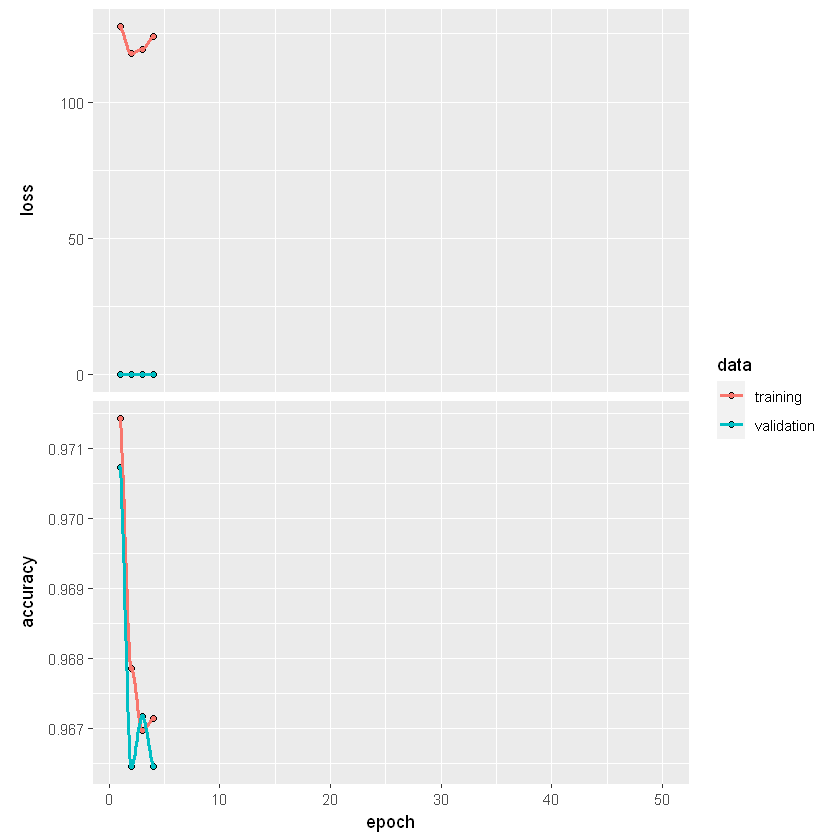

In [204]:
history %>% plot